<div align="center">
    
## Advanced  Data Science Capstone
### ‘Sematic Segmentation model with CamVid dataset’

#### by 

### Andrei Krupnov
    
</div align="center">

Importing required packages first

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
import tensorflow as tf

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%load_ext memory_profiler

Dataset is stored locally.
Providing path information and setting basic variables 

In [3]:
path1 = './CamVid/train/'
path2 = './CamVid/test/'
path3 = './CamVid/val/'

batch_size = 8
latent_dim = 2
dropout_rate = 0.3
start_lr = 0.0001

x_size = 960
y_size = 720
num_classes = 32

In [4]:
def form_path(path, data, labels):
    path_d = path + data
    path_l = path + labels

    path_data = []
    path_labels = []

    for path in os.listdir(path_d):
        if '.png' in path:
            path_data.append(os.path.join(path_d, path))

    for path in os.listdir(path_l):
        if '.png' in path:
            path_labels.append(os.path.join(path_l, path))
            
    return path_data, path_labels

#### ETL

First let's download classification dictionary and have a brief look at label classes and their corresponding RGB values

In [5]:
import pandas as pd

cat = pd.read_csv("./CamVid/class_dict.csv")

catn = np.array(cat[['r','g','b']])
cat.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


I need to convert labeled images into 1hotencoded array. The following function does it and the next one converts the prediction result back to RGB image. 

In [6]:
def hot_labels(inpix):
    hotlabs = np.zeros((inpix.shape[0], y_size, x_size, num_classes),dtype = int)
    bl = catn[:,0]*65536+catn[:,1]*256+catn[:,2]

    for pixn in range(inpix.shape[0]):
        print(pixn)
        a = inpix[pixn]
        b = a[:,:,0]*65536+a[:,:,1]*256+a[:,:,2]

        for idx in range(num_classes):
            hotlabs[pixn,:,:,idx] = np.where(b == bl[idx], 1, 0)

    return hotlabs

In [7]:
def hot2labels(hotlabs, threshold = 0.5):
    
    labels = np.zeros((hotlabs.shape[0],y_size,x_size,3))
    hotlabs = (hotlabs + threshold).astype(int)
    
    for pixn in range(hotlabs.shape[0]):
        print(pixn)
        labs = np.zeros((y_size, x_size)) 
        for j in range(num_classes):
            labs = labs + (hotlabs[pixn,:,:,j]).astype(int) * j
        labs = labs.astype(int)    
        lbls = np.array([catn[la] for la in labs])
        labels[pixn] = lbls
        
    return labels.astype(int)

Now let's download the data.

After first attempts I combined train and test subsets into one train dataset because the number of photos is to low to train a sophisticated model with 32 classes with good enough quality.

In [9]:
path_data0, path_labels0 = form_path(path1, 'train_data/', 'train_labels/')
path_data1, path_labels1 = form_path(path2, 'test_data/', 'test_labels/')

path_data=path_data0+path_data1
path_labels=path_labels0+path_labels1

x_train = [np.array((Image.open(path)).resize((x_size, y_size))) for path in path_data]
y_train = [np.array((Image.open(path)).resize((x_size, y_size))) for path in path_labels]
 
x_train = np.array(x_train)
y_train = np.array(y_train)

Here I check what does different classes look like if taken separately.

The labeling quality is very high.

In [14]:
pixn = 10
a = y_train[pixn]
b = a[:,:,0]*65536+a[:,:,1]*256+a[:,:,2]
bl = catn[:,0]*65536+catn[:,1]*256+catn[:,2]

c = np.zeros((y_size, x_size))
for idx in range(num_classes):
    c = c + np.where(b == bl[idx], 1, 0)

d = np.where(b == bl[10], 1, 0)
rows, cols = np.where(c!=1)
print (rows,cols)

[] []


<Figure size 432x288 with 0 Axes>

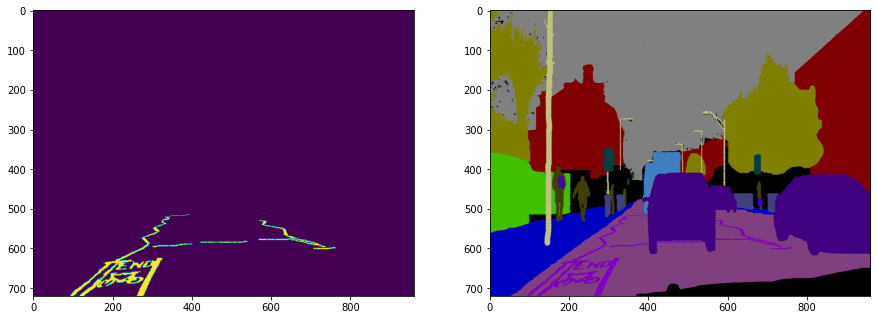

In [15]:
plt.figure()
fig,ax=plt.subplots(1,2, figsize=(15,12))

ax[0].imshow(d)
ax[1].imshow(a)
# plt.imshow(c)
plt.show()

#### Data preprocessing

Converting all the images into 1hotencoded arrays take some time. 

In [17]:
y_train1 = hot_labels(y_train)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Loading and converting labels of validation dataset

In [18]:
path_data, path_labels = form_path(path3, 'val_data/', 'val_labels/')

x_test = [np.array((Image.open(path)).resize((x_size, y_size))) for path in path_data]
y_test = [np.array((Image.open(path)).resize((x_size, y_size))) for path in path_labels]
 
x_test = np.array(x_test)
y_test = np.array(y_test)

In [19]:
y_test1 = hot_labels(y_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


This is to check that both encoding and decoding functions work properly.

In [20]:
labels = np.zeros((y_size,x_size,3))
    
pixn = 1

labs = np.zeros((y_size, x_size)) 
for j in range(num_classes):
    labs = labs + y_train1[pixn,:,:,j]*j
labs = labs.astype(int)    
lbls = np.array([catn[la] for la in labs])
#labels[pixn] = lbls

a = y_train[pixn]

<Figure size 432x288 with 0 Axes>

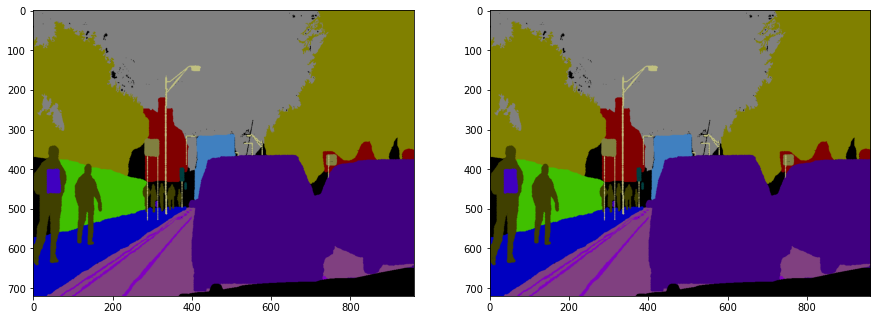

In [21]:
plt.figure()
fig,ax=plt.subplots(1,2, figsize=(15,12))

ax[0].imshow(lbls)
ax[1].imshow(a)
# plt.imshow(c)
plt.show()

In [22]:
shape = x_train[1].shape

print(len(x_train))
print(len(x_test))

601
100


In [23]:
shape

(720, 960, 3)

In [24]:
xfig = int(shape[1]/shape[0]*10)
yfig = 10

print(xfig, yfig)

13 10


Let's print some random images along with corresponding labels

<Figure size 432x288 with 0 Axes>

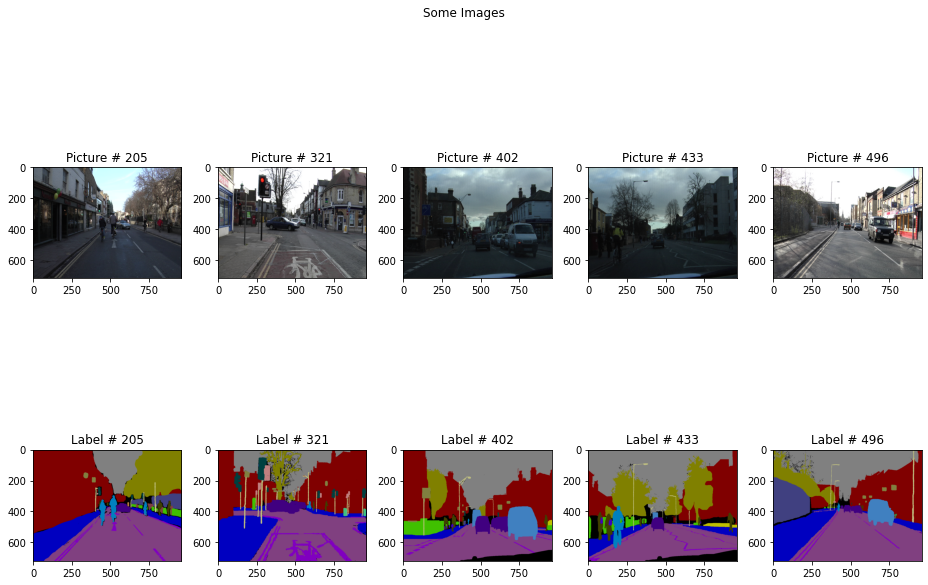

In [25]:
picnum = []
numph = 5
for j in range(numph):
    picnum.append(np.random.randint(0,len(x_train)))
picnum = sorted(picnum)

plt.figure() #(figsize=(10,30))
fig,ax=plt.subplots(2,numph, figsize=(xfig,yfig))
fig.suptitle("Some Images")
#idx=10

for j in range(5):
    ax[0,j].imshow(x_train[picnum[j]])#.reshape(64,64,3))
    subt = 'Picture # '+ str(picnum[j])
    ax[0,j].set_title(subt)
    subtl = 'Label # '+ str(picnum[j])
    ax[1,j].imshow(y_train[picnum[j]])#.reshape(64,64,3))
    ax[1,j].set_title(subtl)        
#    idx+=100
            
plt.tight_layout()
plt.show()

##### Modelling part

First we need to import all required packages 

In [26]:
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, BatchNormalization, ZeroPadding2D, Cropping2D
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model
from keras import preprocessing

from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.metrics import Accuracy
from keras import backend as K

This is the model.<br> I intentionally left commented out lines that resemble my evolutuion of thoughts). <br>
3 previous models (0 to 2) were deleted for not wasting to much space on evolution exibition)

In [27]:
def create_model3():
    input_img = Input(shape = shape)
    
#    x = ZeroPadding2D (padding = (3,4))(x)
    x = Conv2D(64, kernel_size=3, strides=1, activation = 'relu', padding="same")(input_img)
    x = Conv2D(64, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = MaxPooling2D (2, padding = 'same')(x)
    
#    x = ZeroPadding2D (padding = (3,4))(x) 
    x = Conv2D(128, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2D(128, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)

#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = MaxPooling2D (2, padding = 'same')(x)
#    x = ZeroPadding2D (padding = (2,0))(x)    
 
    
    x = Conv2D(256, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2D(256, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = MaxPooling2D (2, padding = 'same')(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = Conv2D(512, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2D(512, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    #    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = MaxPooling2D (2, padding = 'same')(x)

    x = Conv2D(1024, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Dropout(0.5)(x)
    
    x = Conv2DTranspose(512, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2DTranspose(512, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = UpSampling2D ((2,2))(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = Conv2DTranspose(256, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2DTranspose(256, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = UpSampling2D ((2,2))(x)
#    x = Cropping2D((2,0))(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)

    x = Conv2DTranspose(128, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2DTranspose(128, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = UpSampling2D ((2,2))(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)

#    x = Cropping2D((3,4))(x)

    x = Conv2DTranspose(64, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
    x = Conv2DTranspose(64, kernel_size=3, strides=1, activation = 'relu', padding="same")(x)
#    x = LeakyReLU()(x)
#    x = BatchNormalization()(x)
    x = UpSampling2D ((2,2))(x)
#    x = Conv2DTranspose(2, kernel_size=3, strides=2, activation = 'relu', padding="same")(x)
    x = Conv2DTranspose(32, kernel_size=1, strides=1, activation = 'softmax', padding="same")(x)
#    x = UpSampling2D ((2,2))(x)
#    x = LeakyReLU(0.2)(x)
#    x = BatchNormalization()(x)
#    x = Dense(256*256*3, activation='relu')(x)
    label_img = Reshape((y_size, x_size, num_classes))(x)
    
    labeler = Model(input_img, label_img)
    
    return labeler

In [28]:
labeler3 = create_model3()
labeler3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 720, 960, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 720, 960, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 720, 960, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 360, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 360, 480, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 360, 480, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 240, 128)     0     

It looks like it will take quite a time to train a model like this. 

In [29]:
from keras.optimizers import Adam, RMSprop

labeler3.compile(optimizer=Adam(start_lr), loss='CategoricalCrossentropy')

In [30]:
model_weights_save_path = './weights/labeler3_weights'

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=model_weights_save_path,
                                       monitor="val_loss",
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode="auto"),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [20]:
#labeler3 = load_model("labeler3_1.h5")
#labeler3 = load_model("./CamVid/model/labeler3")

I trained this model in 4 approaches: first 10 epochs to ensure that it goes in right direction, than 20 more, than 120 more, and finally 350 more. So there're 500 epochs in total.

In [21]:
%%time
batch_size=4

labeler3.fit(x_train, y_train1, shuffle=True, epochs=350, 
             batch_size=batch_size, 
             validation_data=(x_test, y_test1),
#             callbacks=my_callbacks, 
             verbose=1)

Epoch 1/350
151/151 [==============================] - 129s 852ms/step - loss: 0.0787 - accuracy: 0.0067 - val_loss: 0.4503 - val_accuracy: 0.0047
Epoch 2/350
151/151 [==============================] - 111s 734ms/step - loss: 0.0745 - accuracy: 0.0071 - val_loss: 0.4310 - val_accuracy: 0.0035
Epoch 3/350
151/151 [==============================] - 125s 826ms/step - loss: 0.0741 - accuracy: 0.0072 - val_loss: 0.4329 - val_accuracy: 0.0050
Epoch 4/350
151/151 [==============================] - 124s 824ms/step - loss: 0.0738 - accuracy: 0.0070 - val_loss: 0.4462 - val_accuracy: 0.0059
Epoch 5/350
151/151 [==============================] - 133s 879ms/step - loss: 0.0735 - accuracy: 0.0069 - val_loss: 0.4441 - val_accuracy: 0.0044
Epoch 6/350
151/151 [==============================] - 137s 908ms/step - loss: 0.0724 - accuracy: 0.0069 - val_loss: 0.4419 - val_accuracy: 0.0049
Epoch 7/350
151/151 [==============================] - 175s 1s/step - loss: 0.0724 - accuracy: 0.0068 - val_loss: 0.44

500 epochs seem to be enough because there's no more progress in val_loss decrease.<br>
Let's save the model for future use.

In [26]:
labeler3.save("labeler3_2.h5")
labeler3.save("./CamVid/model/labeler3")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./CamVid/model/labeler3\assets


When doing prediction part I encountered a TF bug: it didn't allow me to do predictions even with batch size of 1 showing OOM error. So I had to force switch to CPU (and with this was able even to increase batch size in 2).

In [22]:
%%time
batch_size=8

# x_test = tf.convert_to_tensor(x_test)
with tf.device('/cpu:0'):
    %memit predicted = labeler3.predict(x_test, batch_size=batch_size, verbose=1)
# predicted = tf.keras.Model.predict(labeler3, x_test, batch_size=batch_size)

13/13 [==============================] - 127s 10s/step
peak memory: 59675.41 MiB, increment: 10303.92 MiB
Wall time: 3min 17s


Now let's convert predictions to visual format and see what we've got.

In [23]:
predict = hot2labels(predicted)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [55]:
def show_predict(predict_x, predict_y, predict, maxnum):

    picnum = []
    numph = 3
    for j in range(numph):
        picnum.append(np.random.randint(0,maxnum))
    picnum = sorted(picnum)
    
    plt.figure() 

    plx = 3
    fig,ax=plt.subplots(numph,plx,figsize=(15,12)) #xfig,yfig))
    fig.suptitle("Predicted Images")

    for j in range(numph):
        ax[j][0].imshow(predict_x[picnum[j]])
        ax[j][0].set_title('Ground truth #' + str(picnum[j]))

        ax[j][1].imshow(predict_y[picnum[j]])
        ax[j][1].set_title('True label #' + str(picnum[j]))

        ax[j][2].imshow(predict[picnum[j]])
        ax[j][2].set_title('Predicted label #' + str(picnum[j]))
            
    # plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

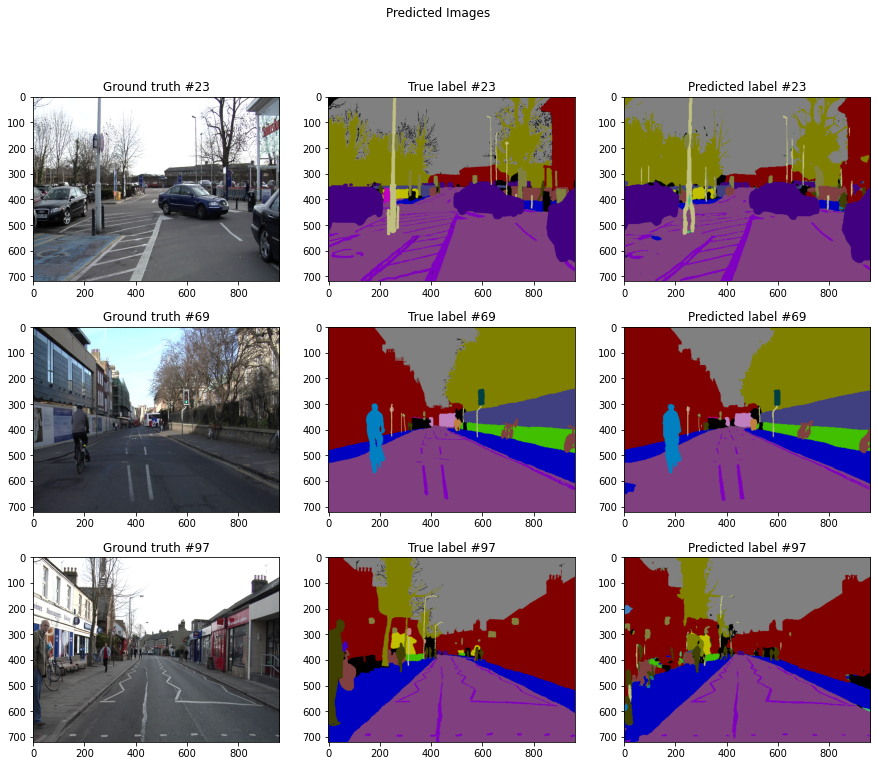

In [61]:
show_predict(x_test, y_test, predict, 100)

It looks like prediction quality is good indeed.<br> 
The only problem (which was anticipated in advance) is with label classes that have very small share in total distribution as shown at the diagram:<br>
![](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/pr/DataPercents_s.jpg)<br>
This is due to the fact that the features associated with these rare categories and their irregular representations on images are hard to identify. At least with the training dataset of only 600 images.<br>
But most of categories are predicted with high precision. 